# NLP Art Generation

Reilly Farrell, Chris He <br>
Any ran out of input errors have to be rerun!
<br>
<br>
In this Notebook, natural language processing is utilized to generate existing paintings. Generation will be based on sentiment analysis done on user input, pulled from a collection of 4000+ famous paintings, each annotated with a set of emotions that the piece brings to mind. We wanted to combine our knowledge of natural language processing techniques with a real-world, interactive visual application that allows users to describe objects and emotions and bring that before their eyes. 
<br>
<br>
Running 1 through 6 and then altering the input for (Final) is the proper ordering to generate art.

### Imports 1

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd
import nltk
from nltk.corpus import brown
from gensim.models import Word2Vec
# from keras.layers import Embedding
# from keras.layers import GlobalAveragePooling1D
# from keras.layers import TextVectorization
# from keras.layers import LSTM
# from keras.layers import InputLayer
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from tensorflow import keras
import numpy as np
from PIL import Image
import requests
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import requests
import csv
import pandas as pd
import tqdm
import random
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.metrics import *
from nltk import word_tokenize
from nltk.stem import *
from nltk import pos_tag, word_tokenize
from nltk.data import find
import gensim
import spacy
from spacy import displacy
import urllib.request
import PIL
from PIL import Image
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.data import find



###################################
from google.colab import drive
drive.mount('/content/drive')


###########################
nltk.download('brown')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('word2vec_sample')

Mounted at /content/drive


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


True

In [2]:
!sudo pip install gensim --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


### Painting Object Detection Initialization 2

This code is used to detect objects in the paintings data set so we can not only find paintings that match the sentiment of our query but also paintings that share objects with the query
<div>Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved

In [3]:
# https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

def display_image(image, visuals=False):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  if visuals:
    plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              visuals=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
 
  if visuals:
     print("Image downloaded to %s." % filename)
     display_image(pil_image, visuals=visuals)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

2.8.2
The following GPU devices are available: 


In [4]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [5]:
def createDownloadImagePath(image_url):
  return download_and_resize_image(image_url, 1280, 856, True)

In [6]:
def run_detector(detector, path, visuals=False):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}
  if visuals:
    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)

    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"])

    display_image(image_with_boxes, visuals=True)

  if not visuals:
    return result["detection_class_entities"], result["detection_scores"]

In [7]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

### Neural Network Setup 3

In [8]:
def createTokenizer(textData):

  #Create a tokenizer and return it along with the encoded sequences
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(textData)
  encoded = pad_sequences(tokenizer.texts_to_sequences(textData), maxlen=100)
  return tokenizer, encoded


Here we download the [GOEmotions data set](https://huggingface.co/datasets/go_emotions) for sentiment analysis tasks. <br> Originally [another](https://huggingface.co/datasets/emotion) emotions dataset was to be used; however, the results were subpar. The dataset did not fit the queries we were using due to all the data being in the first person.


In [9]:
#Download the emotions dataset used for getting the sentiment from text
gdd.download_file_from_google_drive(file_id='1-SCqY6eEma9HXGGz-VVmmMA35dnmQi_J',
                                    dest_path='./sample_data/go_emotions_dataset.csv', overwrite=True
                                    )

In [10]:
#Open and process data set
file = open('./sample_data/go_emotions_dataset.csv')
csvreader = csv.reader(file)
header = []
GOheader = next(csvreader)

GOrows = []
for row in csvreader:
  # GOrows.append(row)
  GOrows.append(row[:len(row) - 1])

In [11]:
# GOheader # emotions labels in GO dataset

In [12]:
GONNmodelLabels = GOheader[3:]
GONNmodelLabels.remove('neutral') #Neutral is removed from the entire dataset due to results being more interesting and better capture the sole emotion of sentences without it

In [13]:
#Setup Nueral Network model
GOData = []
GOTrainData = []
GOValDataX = []
GOTestData = []

for item in GOrows:
  GOData.append(item[1])

for item in GOrows[:150000]:
  GOTrainData.append(item[1])

for item in GOrows[150000:170000]:
  GOValDataX.append(item[1])

for item in GOrows[170000:]:
  GOTestData.append(item[1])

print(f'Sample GOTrainDataset entry:{GOTrainData[1]}')
print(f'GO Dataset is of length {len(GOTrainData)}')

Sample GOTrainDataset entry: >sexuality shouldn’t be a grouping category It makes you different from othet ppl so imo it fits the definition of "grouping" 
GO Dataset is of length 150000


In [14]:
GOTokenizer = Tokenizer() #tokenize and encode X value sentences for training, testing, and validation
GOTokenizer.fit_on_texts(GOData)
GOencoded = pad_sequences(GOTokenizer.texts_to_sequences(GOTrainData), maxlen=100)
GOValDataXEncoded = pad_sequences(GOTokenizer.texts_to_sequences(GOValDataX), maxlen=100)
GOTestDataEncoded = pad_sequences(GOTokenizer.texts_to_sequences(GOTestData), maxlen=100)
# len(GOTestDataEncoded)

In [15]:
#Create Y vectors for model's training, testing, and validation
GOyValsTrain = []
for item in GOrows[:150000]:
  GOyValsTrain.append(list(map(int, item[3:])))
GOmax_words = len(GOTokenizer.word_counts) + 1
print(f'GO dataset max words: {GOmax_words}')
print('GO Y vector sample:')
print(GOyValsTrain[0])

GOyValsValidation = []
for item in GOrows[150000:170000]:
  GOyValsValidation.append(list(map(int, item[3:])))

GOyValsTest = []
for item in GOrows[170000:]:
  GOyValsTest.append(list(map(int, item[3:])))


GO dataset max words: 33083
GO Y vector sample:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


### Train/Load GO NN Model 4  [INPUT REQUIRED]

In [16]:
#Utilized to stop training after certain threshold is met
class ThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(ThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True


Either download the pretrained model [here](https://drive.google.com/drive/folders/1-HjroL50OwUzL3Ds7wuXOIypASGMUNiG?usp=sharing) (download the containing folder, extract, ) and update GO_NN_MODEL_LOAD_DIR to be the directory of the model folder or create a new model from scratch by setting CREATE_NEW_GO_NN_MODEL and TRAIN_MODEL to True and setting the appropriate save directory ****** update instructions (download folder, unzip,)


In [17]:
#Model construction

CREATE_NEW_GO_NN_MODEL = False #@param ['True', 'False'] {type:"raw"}
TRAIN_MODEL = False #@param ['True', 'False'] {type:"raw"}
# GO_NN_MODEL_TRAIN_THRESHOLD = 0.7 #@param {type:"slider", min:0.05, max:1, step:0.05}
GO_NN_MODEL_SAVE_DIR = '' #@param {type: 'string'}
GO_NN_MODEL_LOAD_DIR = '/content/drive/MyDrive/NLPFinalProj/go_nn_model_no_n' #@param {type: 'string'}

# callback = ThresholdCallback(threshold=GO_NN_MODEL_TRAIN_THRESHOLD)

GO_NN_OPTIMIZER = 'adam'
GO_NN_LOSS = 'binary_crossentropy'

BLOCK = False
if(CREATE_NEW_GO_NN_MODEL):
  GONNModel = Sequential()
  GONNModel.add(layers.Embedding(GOmax_words, 500)) #The embedding layer (Testing began at 200)
  GONNModel.add(layers.LSTM(512,dropout=0.3)) #Our LSTM layer used to be 256 but 512 works better
  # GONNModel.add(layers.LSTM(256,dropout=0.2)) #Our LSTM layer (Adding another LSTM layer did not improve performance)
  # GONNModel.add(Activation("relu")) Adding an activation layer worsened performance
  GONNModel.add(layers.Dense(len(GOyValsTrain[0]),activation='sigmoid'))

  # GONNModel.compile(optimizer=GO_NN_OPTIMIZER,loss=GO_NN_LOSS, metrics=['accuracy'])
  GONNModel.compile(optimizer=GO_NN_OPTIMIZER,loss=GO_NN_LOSS, metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=3)])
  if GO_NN_MODEL_SAVE_DIR == GO_NN_MODEL_LOAD_DIR:
    check = input("Save and Load directory are the same" +  "\n" + "this will overwrite stored model" + "\n" + "are you sure you want this?" + "\n" + "enter Y to confirm" + "\n")
    if check !='Y':
      BLOCK = True


else:
  GONNModel = keras.models.load_model(GO_NN_MODEL_LOAD_DIR)
  GONNModel.compile(optimizer=GO_NN_OPTIMIZER,loss=GO_NN_LOSS, metrics=['accuracy'])
  GONNModel.compile(optimizer=GO_NN_OPTIMIZER,loss=GO_NN_LOSS, metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=3)])


In [18]:
#Train the model if training is enabled
if TRAIN_MODEL:

  if BLOCK:
    raise Exception("Trained model is potentially being overwritten with new model; please ensure this is intentional by re-running Train GO NN Model Section and entering Y")

  for ii in range(15):
    history = GONNModel.fit(GOencoded, np.asarray(GOyValsTrain), epochs=1, validation_data=(GOValDataXEncoded, np.asarray(GOyValsValidation)))
    GONNModel.save(GO_NN_MODEL_SAVE_DIR)

###Bayes Model Initialization 5

If ran out of input, re-run

In [19]:
gdd.download_file_from_google_drive(file_id='1NN4r_lTuDVERJAqanyut_KFlVklpc7GA',
                                    dest_path='./sample_data/bayes.pkl', overwrite=True
                                    )
with open('./sample_data/bayes.pkl', 'rb') as f:
    clf = pickle.load(f)

count_vect = CountVectorizer()


bayesData = []

X_train_counts = count_vect.fit_transform(GOData[:200])

X_train_counts.shape


tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_train_tfidf.shape


(200, 968)

###Painting Sentiment label setup 6

For mapping sentiments to paintings we used the following [dataset](http://saifmohammad.com/WebPages/wikiartemotions.html) that has paintings labelled with emotions

In [20]:
PaintingDataTsv = [] 
# download open .tsv file
gdd.download_file_from_google_drive(file_id='1-HYVh9zjrEYKqZNi9QzfIlDrcT0bZ6ru',
                                    dest_path='./sample_data/WikiArt-info.tsv', overwrite=True
                                    )
with open("./sample_data/WikiArt-info.tsv") as file:
    tsv_file = csv.reader(file, delimiter="\t")
     
    # printing data line by line
    for line in tsv_file:
        PaintingDataTsv.append(line)

        
# download and open more detailed version of dataset
gdd.download_file_from_google_drive(file_id='1-06Zi9DuoxcfUqcZt9TrG8nrF4FEtE4b',
                                    dest_path='./sample_data/WikiArt-Emotions-Ag5.tsv', overwrite=True
                                    )
PaintingSentimentsTsv = [] 
# open .tsv file
with open('./sample_data/WikiArt-Emotions-Ag5.tsv') as file:

    tsv_file = csv.reader(file, delimiter="\t")
    # printing data line by line
    for line in tsv_file:
        PaintingSentimentsTsv.append(line)

        
# PaintingSentimentsTsv[0][29:49] #ImageOnly Sentiments
# PaintingSentimentsTsv[2][29:49] #ImageOnly Sentiment Values
# PaintingDataTsv[1] Sample Data

In [21]:
paintingCodes = [] #List of ID tags for paintings
for ii in PaintingSentimentsTsv:
  paintingCodes.append(ii[0])

In [22]:
formatPaintings = [] #List that contains all relevant data for each painting rather than having to access two datasets
failed = []
for ii in range(len(PaintingDataTsv) - 1):
  temp = []
  temp.append(PaintingDataTsv[ii + 1][0])
  if temp[0] not in paintingCodes:
    continue
  search = paintingCodes.index(temp[0])
  temp.extend(PaintingSentimentsTsv[search][29:49])
  temp.append(PaintingDataTsv[ii + 1][5])
  formatPaintings.append(temp)

In [23]:
sentimentValToLabels = [] #All the sentiments present in the labelled paintings
for ii in PaintingSentimentsTsv[0][29:49]:
  split = ii.split(' ')
  sentimentValToLabels.append(split[1])

In [24]:
sentimentValToLabels[5:15] # was using this small subset that works with the brown dataset but decided to not use embeddings to map emotions)
# sentimentValToLabels.remove('shyness') removed due to brown dataset not having shyness
# sentimentValToLabels

['disgust',
 'fear',
 'gratitude',
 'happiness',
 'humility',
 'love',
 'optimism',
 'pessimism',
 'regret',
 'sadness']

In [25]:
# Load word2vec Google model https://code.google.com/archive/p/word2vec/
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
modelNews = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

In [26]:
# sentimentMap[3:len(sentimentMap) - 1] #All possible sentiments

In [27]:
print(gensim.__version__)

3.6.0


In [28]:
#Params for training the brown model
EMBEDDINGS_SIZE = 200
sg = 1
window = 5
min_count = 1
modelBrown = gensim.models.Word2Vec(brown.sents(), size= EMBEDDINGS_SIZE, window= window, min_count= min_count, sg= sg)

#Download and load brown word2vec model
gdd.download_file_from_google_drive(file_id='12DRWvxAVHl79aa4JCcQ7d7TqzZYIPnev',
                                    dest_path='./sample_data/brown.embedding', overwrite=True
                                    )

# modelBrown = gensim.models.Word2Vec.load('/content/drive/MyDrive/NLPFinalProj/brown.embedding')

In [29]:
#Sorting tuple function
# https://www.geeksforgeeks.org/python-program-to-sort-a-list-of-tuples-by-second-item/
def Sort_Tuple(tup): 
  
    # reverse = None (Sorts in Ascending order) 
    # key is set to sort using second element of 
    # sublist lambda has been used 
    tup.sort(key = lambda x: x[1], reverse=True) 
    return tup 

In [30]:
#Download and read generated data set with painting sentiments and objects that were tagged via object detection
gdd.download_file_from_google_drive(file_id='1pSDlrtP4XxEjgF_4FJDvJ__Zze5yJlX2',
                                    dest_path='./sample_data/paintDescrUp.csv', overwrite=True
                                    )
file = open('./sample_data/paintDescrUp.csv')
csvreader = csv.reader(file)
paintDescHeader = []
paintDescHeader = next(csvreader)
rowsPaintDesc = []
for row in csvreader:
        rowsPaintDesc.append(row)

        
# rowsPaintDesc[0] #example of paintings objects
# PaintingDataTsv[0]

###Sentiment -> Art (Final)

In [35]:
st = PorterStemmer() #Stemmer to tag the nouns in painting titles so we can add them to the list of objects in each painting
paintingsWithObjects = [] #Get every painting's objects 
for paint in rowsPaintDesc:
  id = paint[0]
  labels = []
  for item in range(2, len(paint), 2):
    splt = paint[item].split('\'')
    noun = splt[1].split(' ')
    if len(noun) != 1:
      labels.append(noun[1].lower())
    else:
      labels.append(splt[1].lower())

  titleLabels = []
  #Tokenize, get nouns, and add them to a painting's objects
  for ii in PaintingDataTsv[1:]:
    if(ii[0] == id):
        title = ii[3]
        break
  titleForm = []
  for ii in word_tokenize(title):
    titleForm.append(st.stem(ii))
  
  tagged = nltk.pos_tag(titleForm)
  for ii in tagged:
    if ii[1] == 'NN':
      titleLabels.append(ii[0])

  #create list with all of paintings objects and ensure there are no duplicates
  out = []
  out.append(id)
  out.append(paint[1])
  toAddTitleLabels = set(titleLabels)
  out.append(list(set(labels)))
  out[2].extend(toAddTitleLabels)
  paintingsWithObjects.append(out)






Change the parameters to generate NLP art <br>
Input: 
> text that will drive the art generation

sentimentModel: 

> Use a Bayes model or Neural Network for sentiment analysis

embeddingsModel: 
> Use the brown corpus embeddings, google w2v embeddings, or no embeddings to map unknown objects to known objects seen by the object detector

posTagger:
> Use the NLTK part of speech tagger or Spaccy tagger or no tagger for tagging nouns and using them to find objects in the art data set

sentimentsUsed
> The top N sentiments that the sentimentModel classifies will be used to find paintings that match these sentiments

labelMapping
> choose between two manual mappings of GO emotions -> painting emotions

displayDetailedStats
> Choose if you want detailed statistics on the generation to be displayed

displayObjectDetection
>Choose if you want the object detection algorithm to show its results on the chosen painting

In [36]:
input =   "Ship at sea crashing against rocks"         #@param {type: 'string'}
sentimentModel = 'Neural Net' #@param ['Neural Net', 'Bayes'] {type:"string"}
embeddingsModel = 'Google News' #@param ['Brown', 'Google News', 'None'] {type:"string"}
posTagger = 'Spacy' #@param ['NLTK', 'Spacy', 'None'] {type:"string"}
sentimentsUsed = 3 #@param {type:"slider", min:1, max:10, step:1}
labelMapping = 'Type B' #@param ['Type A', 'Type B'] {type:"string"}
displayDetailedStats = True #@param ['True', 'False'] {type:"raw"}
displayObjectDetection = True #@param ['True', 'False'] {type:"raw"}

embInfo = []
tagInfo = []
sentModelInfo = []
labelMapInfo = []
totalMatches = 0
totalSentimentMatches = 0
outOfDict = []



#Select embedding model
if embeddingsModel == 'Brown':
  model = modelBrown
elif embeddingsModel == 'Google News':
  model = modelNews



objects = []

#Initialize embeddings
if embeddingsModel != 'None':
  for painting in paintingsWithObjects:
    for obj in painting[2]:
      if obj in model.wv.vocab:
        #Only add objects in the embedding model's dictionary
        objects.append(obj)

else: #If we are not using embeddings, add all objects to the list of objects
  for painting in paintingsWithObjects:
    for obj in painting[2]:
      objects.append(obj)

#Prevent duplicates
embObjs = set(objects)





inputForm = []
#tokenize input
for ii in word_tokenize(input):
  # inputForm.append(st.stem(ii)) No longer stemming inputs
  inputForm.append(ii)
  
query = []
#Use POS tagger if needed
if posTagger == 'NLTK':
  tagged = nltk.pos_tag(inputForm)
  for ii in tagged:
    tagInfo.append((ii[0], ii[1]))
    #Only add nouns to query
    if ii[1] == 'NN' or ii[1] == 'NNS':
      query.append(ii[0])

elif posTagger == 'Spacy':
  nlp = spacy.load("en_core_web_sm")
  tagged = nlp(input)
  for ii in tagged:
    tagInfo.append((ii.text, ii.pos_))
    if ii.pos_ == 'NOUN':
      #only add nouns to painting query
      query.append(ii.text)

#Add everything to query if no tagger is used
elif posTagger == 'None':
  tagged = input.split(' ')
  for ii in tagged:
    query.append(ii)

possible = []
#remove duplicates
querySet = set(query)


mappedNouns = []
for noun in list(querySet):
  if noun in embObjs:
    #if the noun is already in the seen nouns by the object detector, append it
    mappedNouns.append(noun)
  #if noun has not been seen, attempt to use embeddings to get the most similar noun
  else:
    try:
      mostSim = model.most_similar(positive=noun, topn=1)
      for sims in mostSim:
        embInfo.append((noun, sims[0]))
        mappedNouns.append(sims[0])
    except: 
      outOfDict.append(noun)
      continue

objDetected = set(mappedNouns)

#go through each painting and create a tuple of (painting, matching objects)
for paints in paintingsWithObjects:
  currObjs = set(paints[2])
  overlap = len(objDetected.intersection(currObjs))
  if(overlap!= 0):
    #if there is at least one matching object, add painting to possible matches
    possible.append((paints, overlap))




# sort by most objects matching to least
sortedPossible = Sort_Tuple(possible)


# format input into a list
sample = [input]

#Use sentiment analysis model to get emotion from input
if sentimentModel == 'Neural Net':
  sampleTok = pad_sequences(GOTokenizer.texts_to_sequences(sample), maxlen=100)
  prediction = GONNModel.predict(sampleTok)

elif sentimentModel == 'Bayes':
  X_new_counts = count_vect.transform(sample)
  X_new_tfidf = tfidf_transformer.transform(X_new_counts)
  prediction = clf.predict_proba(X_new_tfidf)



#open file for quick access to emotion mappings
file = open('/content/sample_data/go_emotions_dataset.csv')
csvreader = csv.reader(file)
sentimentMap = next(csvreader)

#get top N labels
indices = np.argsort(prediction[0])[::-1][:sentimentsUsed] #top X

#convert label indices to actual label
for ii in indices:
  sentModelInfo.append(sentimentMap[3:len(sentimentMap) - 1][ii])


#Create list of indices with present label
outCal = []
for item in indices:
  outCal.append(sentimentMap[3:][item])

# Take GO labels and convert them to painting emotion labels (manual mapping done because embeddings yield nonsense results)
if labelMapping == 'Type A':
  manualLabelMap = ['gratitude', 'agreeableness', 'anger', 'disagreeableness', 'agreeableness', 'love', 'surprise', 'love', 'shame', 'disagreeableness', 'disgust', 'disgust', 'shame', 'happiness', 'fear', 'gratitude', 'sadness', 'happiness', 'love', 'shyness', 'optimism', 'arrogance', 'agreeableness', 'gratitude', 'regret', 'sadness', 'surprise', 'netral']
elif labelMapping == 'Type B':
  manualLabelMap = ['trust', 'happiness', 'anger', 'disgust', 'agreeableness', 'love', 'fear', 'surprise',
 'anticipation', 'pessimism', 'disagreeableness', 'digust', 'shame','optimism', 
 'fear', 'gratitude', 'sadness', 'happiness', 'love', 'anticipation', 'optimism',
 'arrogance', 'surprise', 'gratitude', 'regret', 'sadness', 'surprise']


newLabels = []
labels2 = []

####################################################
#Used to take emotions and use embeddings to get most similar emotion but results 
#were bad so changed to manual mapping of model emotions to painting emotions
# for ii in PaintingSentimentsTsv[0][29:49]:
#   split = ii.split(' ')
#   labels2.append(split[1])
# for word in outCal:
#   val = brownEmbeddings.wv.most_similar_to_given(word, labels2[5:15]) 
#   newLabels.append(val)
  
# print(newLabels)
####################################################

#Convert and store the labels
for ii in PaintingSentimentsTsv[0][29:49]:
  split = ii.split(' ')
  labels2.append(split[1])
for word in outCal:
  index = sentimentMap[3:].index(word)
  newLabels.append(manualLabelMap[index])
  labelMapInfo.append((word, manualLabelMap[index]))


#Remove duplicates
cond = set(newLabels)
toCalc = []
for vals in cond:
  #create array of painting labels where sentiment is present
  toChange = labels2.index(vals)
  toCalc.append(toChange)

toCheck = []
#go through all paintings with matching objects and look for matching sentiments
for ii in sortedPossible:
  for jj in formatPaintings:
    if jj[0] == ii[0][0]:
      toCheck.append(jj)
      break
totalMatches = len(toCheck)
if len(toCheck) == 0:
  totalMatches = 0
  toCheck = formatPaintings



target = []
#add the best matches to a tuple to be sorted
for paintings in toCheck:
  found = False
  comp = list(map(int, paintings[1:len(paintings) - 1]))
  score = 0
  for check in set(toCalc):
    if(comp[check] == 1):
      score += 1
      found = True
  if found:
    target.append((paintings, score))

totalSentimentMatches = len(target)
sortedPoss = Sort_Tuple(target)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [37]:
totalFail = False
if target == []:
  try:
    # target = toCheck[0]
    #if there is no sentiment match, select a random painting with the correct objects
    target = random.choice(toCheck)
  except:
    totalFail = True
else:
  #select the best matched painting with correct objects and sentiments
  target = sortedPoss[0][0]


######################## Generation Info ########################
Input: Ship at sea crashing against rocks
Sentiment Model: Neural Net
Word Embeddings Used: Google News
Part of Speech Tagger used: Spacy
Top 3 sentiments used for painting sentiment matching
Label Mapping: Type B
 
######################## Painting Info ########################
Title: The Ship Isabella at Sea
Artist: John Wilson Carmichael
Period: Romanticism
Publish Date: 1820
Wiki Link: https://www.wikiart.org/en/john-wilson-carmichael/the-ship-isabella-at-sea-1820
Author Wiki Link: https://www.wikiart.org/en/john-wilson-carmichael
 
######################## NLP Info ########################
Embeddings mapping  (only unseen objects are mapped):
  Ship -> ship
  rocks -> boulders
 
Part of Speech Tags (Only nouns are used in query):
  Ship -> NOUN
  at -> ADP
  sea -> NOUN
  crashing -> VERB
  against -> ADP
  rocks -> NOUN
 
Raw Sentiment Data (Most confident to least):
  APPROVAL
  ADMIRATION
  CURIOSITY
 
Sentiment 

' '

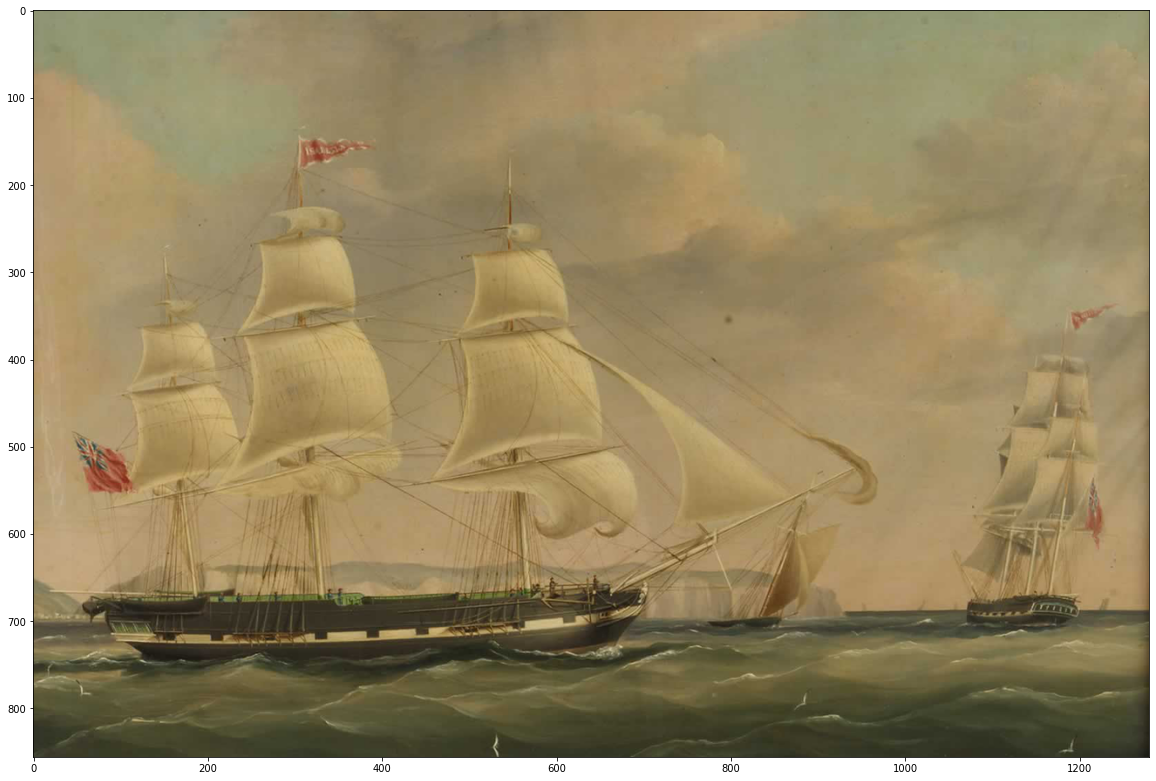

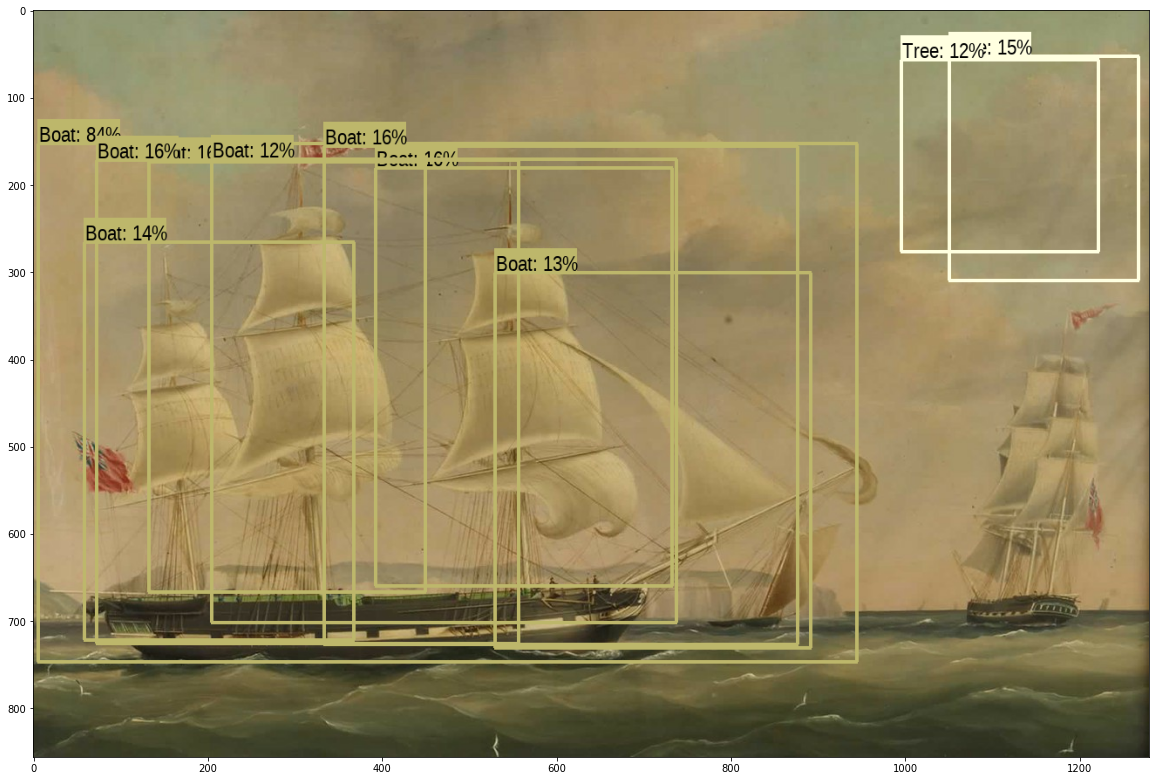

In [38]:
#No paintings have the objects that the query has
if totalFail:
  print('No paintings with matching objects or sentiments was found')

elif (displayDetailedStats and not totalFail):
  print('######################## Generation Info ########################')
  print(f'Input: {input}')
  print(f'Sentiment Model: {sentimentModel}')
  print(f'Word Embeddings Used: {embeddingsModel}')
  print(f'Part of Speech Tagger used: {posTagger}')
  print(f'Top {sentimentsUsed} sentiments used for painting sentiment matching')
  print(f'Label Mapping: {labelMapping}')
  print(' ')
  print('######################## Painting Info ########################')
  for ii in PaintingDataTsv:
    if target[0] == ii[0]:
      print(f'Title: {ii[3]}')
      print(f'Artist: {ii[2]}')
      print(f'Period: {ii[1]}')
      print(f'Publish Date: {ii[4]}')
      print(f'Wiki Link: {ii[6]}')
      print(f'Author Wiki Link: {ii[7]}')
      break

  print(' ')
  print('######################## NLP Info ########################')
  if embeddingsModel != 'None':
    print('Embeddings mapping  (only unseen objects are mapped):')
    for ii in embInfo:
      print(f'  {ii[0]} -> {ii[1]}')
    if len(outOfDict) > 0:
      print(' Words not found in embeddings model dictionary:')
      for ii in outOfDict:
        print(f'  {ii}')
    print(' ')
  if posTagger != 'None':
    print('Part of Speech Tags (Only nouns are used in query):')
    for ii in tagInfo:
      print(f'  {ii[0]} -> {ii[1]}')
    print(' ')
  print('Raw Sentiment Data (Most confident to least):')
  for ii in sentModelInfo:
    print(f'  { ii.upper()}')
  print(' ')
  print('Sentiment Data Mapping:')
  for ii in labelMapInfo:
    print(f'  {ii[0]} -> {ii[1]}')
  print(' ')
  print('######################## Query Info ########################')
  print(f'Total paintings found with at least one matching object: {totalMatches}')
  print(f'Total paintings found with at least one matching sentiment: {totalSentimentMatches}')
  if(totalSentimentMatches != 0):
    print(f'Best match had {sortedPoss[0][1]} matching sentiments (Only counting present sentiments)')
  else:
    print('No paintings with similar objects matched the sentiments, using random painting with correct objects')
  classes = []
  for ii in range(1, len(target[1:len(target) - 1])):
    if target[ii + 1] == '1':
      classes.append(PaintingSentimentsTsv[0][29:49][ii].split(' ')[1])
  print(f'Queried painting sentiments:')
  for ii in classes:
    print(f'  {ii}')
  print(' ')
  print('######################## Painting ########################')

      



if not displayObjectDetection and not totalFail:
# https://gist.github.com/tomvon/ae288482869b495201a0  
  urllib.request.urlretrieve(
    target[len(target) - 1],
    "tImg.png")
  
  img = Image.open("tImg.png")
# from PIL import Image

  mywidth = 800

# img = Image.open('someimage.jpg')
  wpercent = (mywidth/float(img.size[0]))
  hsize = int((float(img.size[1])*float(wpercent)))
  img = img.resize((mywidth,hsize), PIL.Image.ANTIALIAS)
  # img.show()

elif not totalFail:
  run_detector(detector, createDownloadImagePath(target[len(target) - 1]), visuals = True)
  img = ' '



img

### Do painting object detection Test (Optional)

Set image_url to the link of any image and have the algoirthm detect objects

In [ ]:
image_url = "https://uploads3.wikiart.org/images/j-zsef-rippl-r-nai/uncle-piacsek-in-front-of-the-black-sideboard-1906.jpg"  #@param {type: 'string'}

Image downloaded to /tmp/tmpqc0nnfns.jpg.
Found 100 objects.
Inference time:  6.600246429443359


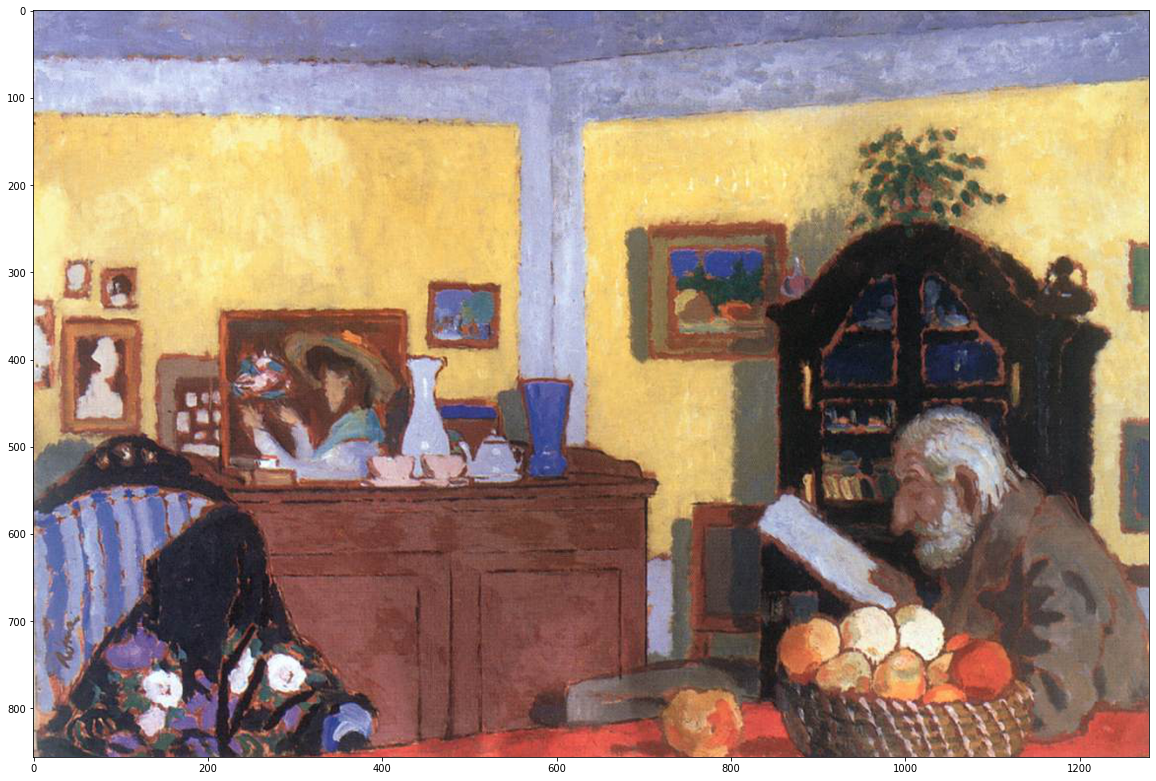

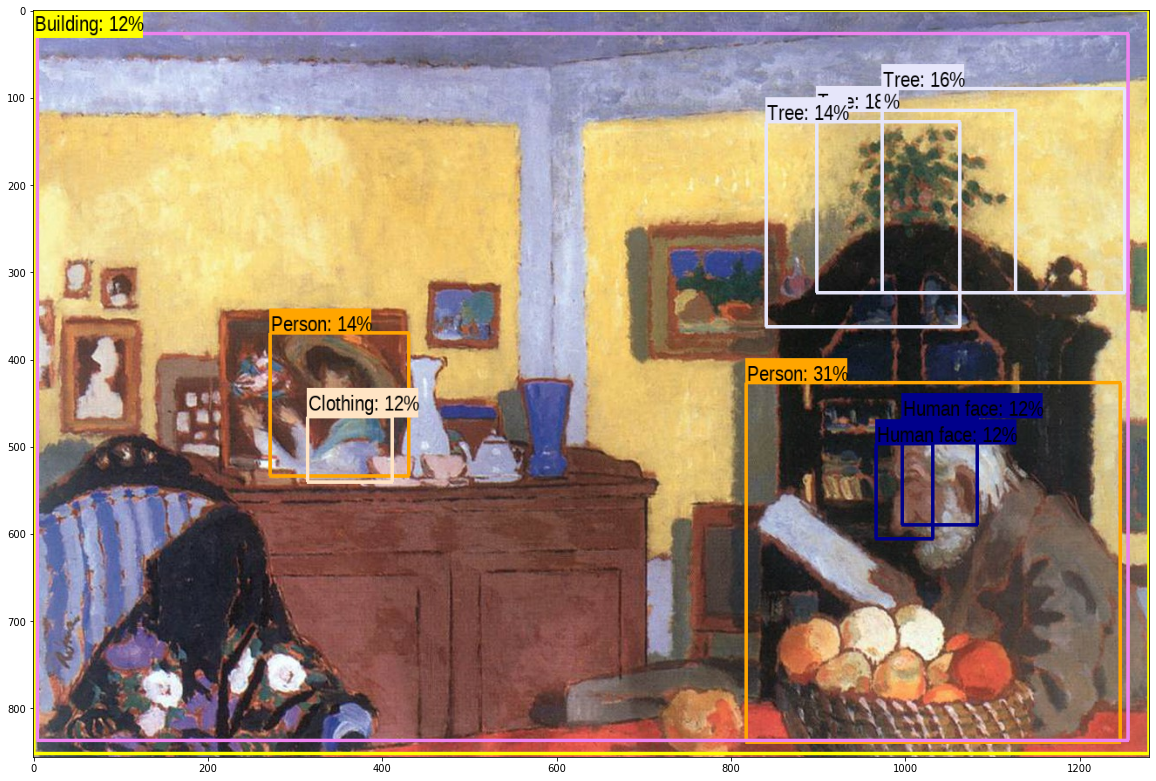

In [ ]:
run_detector(detector, createDownloadImagePath(image_url), visuals = True)

### POS Tagger visualization (Optional)

In [ ]:
#Visualization for sentence tagging
nlp = spacy.load("en_core_web_sm")
doc = nlp("The dog broke the leash and ran off into the woods")
displacy.render(doc, style="dep", jupyter=True)

###Evaluate GO NN MODEL (Optional)

Evaluate NN model

In [ ]:
result = GONNModel.evaluate(GOTestDataEncoded, np.asarray(GOyValsTest))

###Implementation for Naive Bayes Model (DO NOT RUN)

Setup for training data id labeling

In [ ]:
import csv
import pandas as pd

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1-SCqY6eEma9HXGGz-VVmmMA35dnmQi_J',
                                    dest_path='./sample_data/go_emotions_dataset.csv', overwrite=True
                                    )

emo_df_raw = pd.read_csv('./sample_data/go_emotions_dataset.csv', encoding='utf-8')

In [ ]:
# cleaning the data, removing unecessary columns
emo_df_raw = emo_df_raw.drop(['id','example_very_unclear'],axis=1)
emo_df_raw = emo_df_raw[:600]
emo_df_raw = emo_df_raw[(emo_df_raw.neutral != 1)] # remove rows with label 'neutral', irrelevant
emo_df = pd.DataFrame([], columns=emo_df_raw.columns)

# only keep the rows that have an emotion label, ie if any column has value 1
for idx, row in emo_df_raw.iterrows():
  if 1 in row.values:
    emo_df = emo_df.append(row)
emo_df

In [ ]:
# setup data for vectorizer
GOData = emo_df['text']
GOTrainData = emo_df[:200]

In [ ]:
GOData_target = []

# if no label is indicated remove row
for idx, row in emo_df[:200].iterrows():
  col = 1
  for item in row.values:  
    if col < 29 and row[col] == 1:
      GOData_target.append(col)
      break
    col += 1
GOTrainData['label'] = GOData_target

In [ ]:
# preprocess text and tokenizing, link the index value of a word in the vocab
# to its frequency in teh whole training corpus
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(GOTrainData['text'])
X_train_counts.shape

In [ ]:
# divide the number of occurrences of each word by the total number of words 
# to avoid discrepancies in average count values between larger and smaller documents
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train_tfidf, GOData_target)

input = ['i hate anger']
X_new_counts = count_vect.transform(input)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

sentiments_used = 6
prediction = clf.predict(X_new_tfidf)

In [ ]:
indices = np.argsort(prediction[0])[::-1][:sentiments_used] # find the top n predictions
print(indices)

sentiments = []

for i in indices:
  sentiments.append(emo_df.columns[i + 1])
sentiments

###ID objects in paintings (DO NOT RUN)

Setup for generating all the object tags for each painting

In [ ]:
from tqdm import tqdm

In [ ]:
paintingLabels = []

In [ ]:
#Go through each painting and tag the objects then save to a file
for paint in tqdm(formatPaintings):
  toAdd = []
  id = paint[0]
  url = paint[len(paint) - 1]
  downloaded_image_path = download_and_resize_image(url, 1280, 856)
  objs, odds = run_detector(detector, downloaded_image_path)
  toAdd.append(id)
  toAdd.append(url)
  toAdd.append(objs)
  toAdd.append(odds)
  paintingLabels.append(toAdd)


In [ ]:
paintRows = []
for lPaints in paintingLabels:
  entry = []
  entry.append(lPaints[0])
  entry.append(lPaints[1])
  for ii in range(20):
    try:
      entry.append(lPaints[2][ii + 2])
      entry.append(lPaints[3][ii + 2])
    except:
      break
  while(len(entry) < 42):
    entry.append('empty')

  paintRows.append(entry)




In [ ]:
header = ['id', 'url']
for ii in range(20):
  header.append(f'label{ii}')
  header.append(f'confidence{ii}')

In [ ]:
len(paintRows[0])

In [ ]:
paintRows

In [ ]:
import csv
filename = "/content/drive/MyDrive/NLPFinalProj/paintDescr.csv"
    
# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
        
    # writing the fields 
    csvwriter.writerow(header) 
        
    # writing the data rows 
    csvwriter.writerows(paintRows)

###Testing old model with old emotions dataset (DO NOT RUN)

In [ ]:
sentiments

In [ ]:
sample = ['I love love love love love love love you so much']
sampleTok = pad_sequences(tokenizer.texts_to_sequences(sample), maxlen=max_len)
sampleTok.shape

In [ ]:
val = model1.predict(sampleTok)

In [ ]:
toGet = np.argmax(val)
print(sentiments[toGet])
print(val)
#Model would only detect sentiment if it was repeated an unrealistic amount of times

In [ ]:
toCalc = []
newLabel = [embeddings.wv.most_similar_to_given(sentiments[toGet], labels[5:15])]
for vals in newLabel:
  toChange = labels.index(vals)
  toCalc.append(toChange)
print(toCalc)

#Testing using embeddings to map emotions

In [ ]:
target = None
possible = []
for paintings in formatPaintings:
  # all(elem in list1  for elem in list2)
  found = True
  comp = list(map(int, paintings[1:len(paintings) - 1]))
  for check in toCalc:
    if(comp[check] != 1):
      found = False
      break
  if found:
    possible.append(paintings)
    # break


### Old emotions dataset testing + Model (DO NOT RUN)

This was the implementatio of our first NN model with the first person emotions data set. The performance was really bad so we decided to not go forward with its complete implementation

In [ ]:
text_file = open("/content/drive/MyDrive/NLPFinalProj/emotionsTrain.txt", "r")
text_file_data = text_file.read()
trainOne = text_file_data.split('\n')

In [ ]:
print(trainOne[0])

In [ ]:
formattedTrainOne = []
for val in trainOne:
  toAdd = val.split(';')
  formattedTrainOne.append(toAdd)

In [ ]:
print(formattedTrainOne[1])

In [ ]:
xs1 = []
ys1 = []
for item in formattedTrainOne:
  try:
    first = item[0]
    second = item[1]
  except:
    continue
  xs1.append(item[0])
  ys1.append(item[1])


In [ ]:
print((xs1[1]))

In [ ]:
sentiments = []
for item in ys1:
  if item not in sentiments:
    sentiments.append(item)

In [ ]:
sentiments

In [ ]:
yThings = []
for item in ys1:
  if(item == 'sadness'):
    yThings.append([1, 0, 0, 0, 0, 0])
    # yThings.append(0)
  elif(item == 'anger'):
    # yThings.append(1)
    yThings.append([0, 1, 0, 0, 0, 0])
  elif(item == 'love'):
    # yThings.append(2)
    yThings.append([0, 0, 1, 0, 0, 0])
  elif(item == 'surprise'):
    # yThings.append(3)
    yThings.append([0, 0, 0, 1, 0, 0])
  elif(item == 'sadness'):
    # yThings.append(4)
    yThings.append([0, 0, 0, 0, 1, 0])
  else:
    # yThings.append(5)
    yThings.append([0, 0, 0, 0, 0, 1])  


In [ ]:
print(xs1[0])

In [ ]:

embedding_layer = Embedding(1000, 64)

In [ ]:



max_len = 100

tokenizer = Tokenizer()
tokenizer.fit_on_texts(xs1)
sequences = tokenizer.texts_to_sequences(xs1)
max_words = len(tokenizer.word_counts) + 1
out = pad_sequences(sequences, maxlen=max_len)
print(out)

In [ ]:
from keras.layers import Embedding
import numpy as np


In [ ]:
tokenizer, encoded = createTokenizer(xs1)

In [ ]:
#Setup of the model


model1 = Sequential()
model1.add(layers.Embedding(max_words, 300)) #The embedding layer
model1.add(layers.LSTM(128,dropout=0.2)) #Our LSTM layer
model1.add(layers.Dense(6,activation='softmax'))


model1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(encoded, np.asarray(yThings), epochs=1)
model1.save('/content/drive/MyDrive/NLPFinalProj/model1')

In [ ]:
model1 = tf.keras.models.load_model('/content/drive/MyDrive/NLPFinalProj/model1')

In [ ]:
sample = ['i am feeling so scared right now']
sampleTok = pad_sequences(tokenizer.texts_to_sequences(sample), maxlen=max_len)
sampleTok.shape

In [ ]:
val = model1.predict(sampleTok)

In [ ]:
toGet = np.argmax(val)
# out = val.tolist()
# out.index(toGet)
print(sentiments[toGet])
print(val)